Import Important Liberaries


### Alternative Models for Fraud Detection

Given the characteristics of your dataset, including the high imbalance and the need to capture complex patterns, here are some alternative models you could consider:

1.  **LightGBM:** Similar to XGBoost, LightGBM is a gradient boosting framework that is often faster to train and can handle large datasets efficiently. It also has parameters to address class imbalance.

2.  **CatBoost:** Another gradient boosting algorithm that is known for its handling of categorical features and robustness to overfitting. It also has built-in features for dealing with imbalanced data.

3.  **Random Forest:** An ensemble method that can be effective for classification tasks. While not as inherently suited for imbalanced data as gradient boosting models, you can use techniques like undersampling or oversampling the data, or adjusting class weights within the Random Forest algorithm.

4.  **Support Vector Machines (SVM):** SVMs can be used for classification and are effective in high-dimensional spaces. You can use weighted SVMs to give more importance to the minority class. However, training can be slow on very large datasets.

5.  **Neural Networks:** Deep learning models, such as those built with TensorFlow or PyTorch, can learn complex patterns and representations from the data. You would need to carefully design the network architecture and consider techniques like weighted loss functions or data resampling to handle the class imbalance.

The best choice of model often depends on the specific characteristics of your data, the computational resources available, and the desired trade-off between performance metrics like precision and recall. It's often a good practice to experiment with several models and compare their performance using appropriate evaluation metrics for imbalanced datasets.

In [7]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
df=pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
df.isnull().sum() #missing values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
df.nunique() # We are checking all the unique values in all the features or variables

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [12]:
df.duplicated().sum()

np.int64(0)

We have categorical variables like type so we will use One Hot Encoding to convert it into numeric.

In [13]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

**nameOrig and nameDest are high-cardinality categoricals**
so we'll drop them.

In [14]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [15]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [16]:
df['isFraud'].value_counts(normalize=True) * 100 # Here we are seeing the proportion of fraud and legit classes

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int64  
 7   isFlaggedFraud  int64  
 8   type_CASH_OUT   bool   
 9   type_DEBIT      bool   
 10  type_PAYMENT    bool   
 11  type_TRANSFER   bool   
dtypes: bool(4), float64(5), int64(3)
memory usage: 412.6 MB


In [18]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,0,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,False,False,True,False


In [19]:
scale_pos_weight = 6354407 / 8213
scale_pos_weight

773.7010836478753

The dataset is highly imbalanced — for every 774 legitimate transactions, there is only 1 fraudulent transaction. This means fraud accounts for less than 0.2% of all transactions. If we directly train a model on such data, it will tend to predict most cases as legitimate.


# EDA

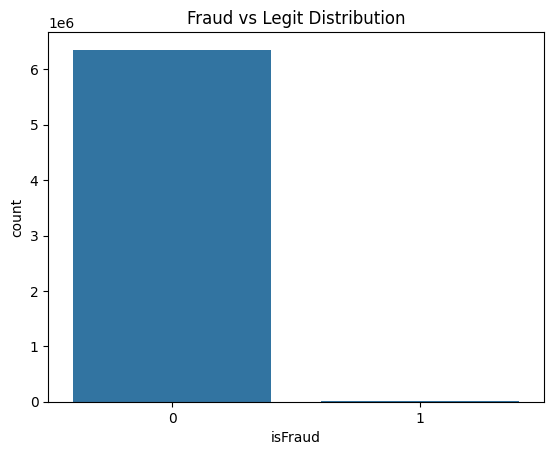

Fraud ratio: 0.001291


In [20]:
y = df['isFraud']
sns.countplot(x=y)
plt.title("Fraud vs Legit Distribution")
plt.show()

fraud_ratio = y.sum() / len(y)
print(f"Fraud ratio: {fraud_ratio:.6f}")


this also shows that target variable is higly imbalanced


In [21]:
X = df.drop(columns=["isFraud"])   # all features
y = df["isFraud"]                  # target

**Now we will train our model but we know that training model is not sufficient so after that we will use some evaluation matrics like precision, recall and f1 score for better performance of our model.**

**We will Split the data in three parts Train (For traning our model),validation (to validate the model) and Test (to use in evaluation matrix)**


**We chose XGBoost because our dataset involves highly imbalanced data and non-linear relationships. XGBoost naturally supports imbalance handling through scale_pos_weight, is very effective at capturing complex fraud patterns**

In [22]:
# 1. Train/Validation/Test split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                                stratify=y_temp, random_state=42)

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False
)
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-aucpr:0.54031
[1]	validation_0-aucpr:0.58429
[2]	validation_0-aucpr:0.62904
[3]	validation_0-aucpr:0.71188
[4]	validation_0-aucpr:0.76030
[5]	validation_0-aucpr:0.77483
[6]	validation_0-aucpr:0.80570
[7]	validation_0-aucpr:0.81107
[8]	validation_0-aucpr:0.83767
[9]	validation_0-aucpr:0.86143
[10]	validation_0-aucpr:0.87713
[11]	validation_0-aucpr:0.88167
[12]	validation_0-aucpr:0.88354
[13]	validation_0-aucpr:0.91092
[14]	validation_0-aucpr:0.91677
[15]	validation_0-aucpr:0.91357
[16]	validation_0-aucpr:0.91561
[17]	validation_0-aucpr:0.91779
[18]	validation_0-aucpr:0.91843
[19]	validation_0-aucpr:0.91898
[20]	validation_0-aucpr:0.92361
[21]	validation_0-aucpr:0.92514
[22]	validation_0-aucpr:0.92648
[23]	validation_0-aucpr:0.92703
[24]	validation_0-aucpr:0.92727
[25]	validation_0-aucpr:0.92871
[26]	validation_0-aucpr:0.92930
[27]	validation_0-aucpr:0.92956
[28]	validation_0-aucpr:0.91283
[29]	validation_0-aucpr:0.93544
[30]	validation_0-aucpr:0.93838
[31]	validation_0-

,objective,'binary:logistic'
,use_label_encoder,False
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,1
,colsample_bynode,1
,colsample_bytree,1
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [23]:
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print("\nPR AUC:", pr_auc)


Confusion Matrix:
 [[952157   1004]
 [    23   1209]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9989    0.9995    953161
           1     0.5463    0.9813    0.7019      1232

    accuracy                         0.9989    954393
   macro avg     0.7731    0.9901    0.8507    954393
weighted avg     0.9994    0.9989    0.9991    954393


PR AUC: 0.9689947948447931


**Our model has performed good as its PR AUC is 0.91 but precision is bit concerning and we can solve it by adjusting threshold value from 0.5 to 0.6 or 0.7 something.**

## Generate Baseline Stats for Drift Detection

**⚠️ IMPORTANT**: Run this ONCE after final preprocessing. These stats represent "normal" data distribution.
Do NOT regenerate casually - these are your ground truth for drift detection.

In [27]:
# Force reload of the module to pick up recent changes
import importlib
import sys
if 'app.drift.reference_stats' in sys.modules:
    del sys.modules['app.drift.reference_stats']

from app.drift.reference_stats import compute_reference_stats, save_reference_stats

# Compute baseline stats from X_train (represents "normal" data distribution)
ref_stats = compute_reference_stats(X_train)

print("Baseline Stats Computed:")
for feature, stats in ref_stats.items():
    print(f"  {feature}: μ={stats['mean']:.2f}, σ={stats['std']:.2f}, range=[{stats['min']:.2f}, {stats['max']:.2f}]")

Baseline Stats Computed:
  step: μ=243.39, σ=142.32, range=[1.00, 743.00]
  amount: μ=179939.73, σ=601961.96, range=[0.00, 92445516.64]
  oldbalanceOrg: μ=834757.26, σ=2890121.70, range=[0.00, 59585040.37]
  newbalanceOrig: μ=855975.61, σ=2925904.76, range=[0.00, 49585040.37]
  oldbalanceDest: μ=1100703.85, σ=3388743.37, range=[0.00, 356015889.35]
  newbalanceDest: μ=1225085.20, σ=3663795.38, range=[0.00, 356179278.92]
  isFlaggedFraud: μ=0.00, σ=0.00, range=[0.00, 1.00]
  type_CASH_OUT: μ=0.35, σ=0.48, range=[0.00, 1.00]
  type_DEBIT: μ=0.01, σ=0.08, range=[0.00, 1.00]
  type_PAYMENT: μ=0.34, σ=0.47, range=[0.00, 1.00]
  type_TRANSFER: μ=0.08, σ=0.28, range=[0.00, 1.00]


In [28]:
# Save baseline stats to file (ONLY RUN ONCE - this is your ground truth)
save_reference_stats(ref_stats, "app/models/reference_stats.json")
print("\n✅ Baseline stats saved! Now ready for drift detection in production.")
print("📝 Do NOT regenerate these casually - they represent your baseline distribution.")

✅ Reference stats saved to app/models/reference_stats.json

✅ Baseline stats saved! Now ready for drift detection in production.
📝 Do NOT regenerate these casually - they represent your baseline distribution.


In [30]:
# X_train is already preprocessed
reference_df = X_train.sample(n=1000, random_state=42)

# Save as CSV (more compatible than parquet - no extra dependencies)
reference_df.to_csv(
    "app/models/reference_data.csv",
    index=False
)

print("✅ Reference data sample saved to app/models/reference_data.csv")
print(f"   Shape: {reference_df.shape}")
print(f"   Used for: Visualization, analysis, and as fallback for drift detection")

✅ Reference data sample saved to app/models/reference_data.csv
   Shape: (1000, 11)
   Used for: Visualization, analysis, and as fallback for drift detection
